# Test two final models (Best and Proposed)

---

### Importing the libraries

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import sys
sys.path.insert(0, '../helpers/')
from plot_graphs import plot_loss, plot_acc

### Setting batch and image size, and importing the datasets 

In [30]:
IMAGE_SIZE = 100
BATCH_SIZE = 32

train = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/train", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
val = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/val", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
test = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/test", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

train = train.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val = val.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
test = test.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

Found 3840 files belonging to 6 classes.
Found 480 files belonging to 6 classes.
Found 480 files belonging to 6 classes.


### Processing images

In [31]:
def process_image(x):
  x = tf.image.adjust_brightness(x, 0.8)
  x = tf.image.adjust_contrast(x, 3)
  x = tf.image.adjust_saturation(x, 2)
  return x

def process_ds(dataset):
  return dataset.map(lambda x, y: (process_image(x), y)).prefetch(tf.data.AUTOTUNE).cache()
  
train_processed = process_ds(train)
val_processed = process_ds(val)
test_processed = process_ds(test)

### Function to generate confusion matrices and get class-wise precision and recall

In [48]:
class_list = ['bike', 'car', 'juggernaut', 'minibus', 'pickup', 'truck']

# Get the labels(y_true) and predictions(y_pred) from the test set
def get_preds_labels(model,test):
  preds = np.argmax(model.predict(test), axis=1)
  labels = []
  for image, label in test.unbatch():
    labels.append(label)
  labels = np.array(labels)

  return labels, preds

# print the classification report and confusion matrix
def print_cm(labels, preds, cm):
  print(classification_report(labels, preds))

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)

  plt.rcParams["figure.figsize"] = (15,8)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()


## 1. Best Model - highest accuracy

> In this section, the best model which will now be trained for 50 epochs with slightly tweaked dropout and learning rates to maximize test accuracy.

### 1.1 Defining the best model

In [58]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_best = keras.Model(inputs, outputs)

model_best.compile(optimizer=keras.optimizers.RMSprop(0.00095), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_best.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_36 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 conv2d_37 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                           

### 1.2 Running the best model

In [59]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="../models/4_best.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_best = model_best.fit(
  train_processed,
  epochs=50,
  callbacks=callbacks_list,
  validation_data=val_processed
)

Epoch 1/50


2022-08-31 04:56:18.199287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.5357 - accuracy: 0.3576

2022-08-31 04:56:29.869178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 13s 95ms/step - loss: 1.5357 - accuracy: 0.3576 - val_loss: 0.9449 - val_accuracy: 0.6583
Epoch 2/50
120/120 [==============================] - 11s 94ms/step - loss: 0.8530 - accuracy: 0.6828 - val_loss: 0.6529 - val_accuracy: 0.7833
Epoch 3/50
120/120 [==============================] - 11s 93ms/step - loss: 0.5615 - accuracy: 0.7995 - val_loss: 0.4636 - val_accuracy: 0.8250
Epoch 4/50
120/120 [==============================] - 11s 93ms/step - loss: 0.3810 - accuracy: 0.8766 - val_loss: 0.3289 - val_accuracy: 0.8854
Epoch 5/50
120/120 [==============================] - 12s 96ms/step - loss: 0.2674 - accuracy: 0.9141 - val_loss: 0.2728 - val_accuracy: 0.9104
Epoch 6/50
120/120 [==============================] - 12s 97ms/step - loss: 0.1993 - accuracy: 0.9354 - val_loss: 0.2363 - val_accuracy: 0.9292
Epoch 7/50
120/120 [==============================] - 12s 99ms/step - loss: 0.1808 - accuracy: 0.9495 - val_loss: 0.2378 - val_accuracy: 0.9271
Epo

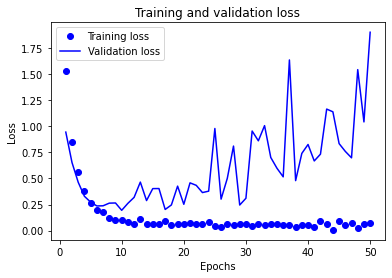

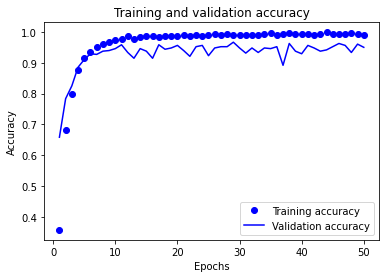

In [67]:
plt.rcParams["figure.figsize"] = (6,4)
plot_loss(history_best)
plot_acc(history_best)

### 1.3 Evaluating test accuracy of the best model

In [61]:
load_model_best = keras.models.load_model("../models/4_best.h5")
load_model_best.evaluate(test_processed)

 1/15 [=>............................] - ETA: 3s - loss: 0.1038 - accuracy: 0.9688

2022-08-31 05:08:19.017520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 31ms/step - loss: 0.2697 - accuracy: 0.9583


[0.2697398364543915, 0.9583333730697632]

---

*Test Accuracy*: **%**

---

### 1.4 Confusion matrix and class-wise precious and recall for proposed model

2022-08-31 05:14:21.023709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.95      1.00      0.98        80
           1       0.97      0.86      0.91        80
           2       0.94      1.00      0.97        80
           3       0.95      0.90      0.92        80
           4       0.91      0.99      0.95        80
           5       0.96      0.93      0.94        80

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480



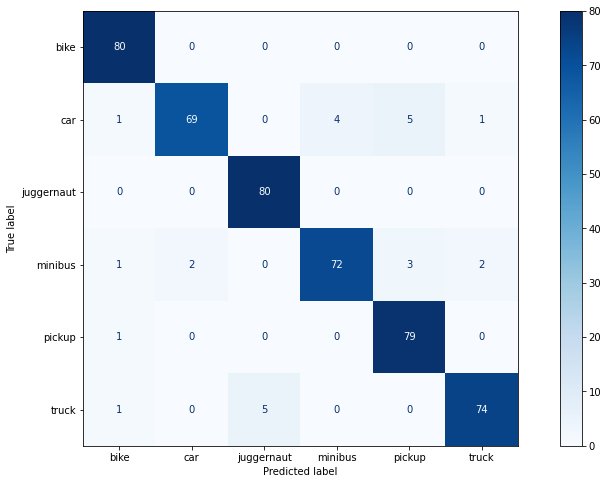

In [62]:
best_labels, best_preds = get_preds_labels(model_best, test_processed)
cm_proposed = confusion_matrix(best_labels, best_preds)
print_cm(best_labels, best_preds, cm_proposed)

----

## 2. Proposed Model - the smallest model that gives the highest accuracy

> In this section, the small proposed model will run for 50 epochs to check the test accuracy it gives.

### 2.1 Defining the proposed model

In [36]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_proposed = keras.Model(inputs, outputs)

model_proposed.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_proposed.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 21, 21, 32)        9248

### 2.2 Running the proposed model

In [38]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10
    ),    
    keras.callbacks.ModelCheckpoint(
        filepath="../models/4_proposed.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_proposed = model_proposed.fit(
  train,
  epochs=50,
  callbacks=callbacks_list,
  validation_data=val
)

Epoch 1/50


2022-08-31 04:13:14.176117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


118/120 [============================>.] - ETA: 0s - loss: 2.4706 - accuracy: 0.1833

2022-08-31 04:13:17.302327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 4s 25ms/step - loss: 2.4593 - accuracy: 0.1828 - val_loss: 1.7755 - val_accuracy: 0.1979
Epoch 2/50
120/120 [==============================] - 3s 23ms/step - loss: 1.7677 - accuracy: 0.2586 - val_loss: 1.6609 - val_accuracy: 0.3979
Epoch 3/50
120/120 [==============================] - 3s 24ms/step - loss: 1.6235 - accuracy: 0.3482 - val_loss: 1.5207 - val_accuracy: 0.3250
Epoch 4/50
120/120 [==============================] - 3s 24ms/step - loss: 1.3860 - accuracy: 0.4839 - val_loss: 1.1510 - val_accuracy: 0.5688
Epoch 5/50
120/120 [==============================] - 3s 23ms/step - loss: 1.1215 - accuracy: 0.5883 - val_loss: 0.7896 - val_accuracy: 0.7438
Epoch 6/50
120/120 [==============================] - 3s 23ms/step - loss: 0.9369 - accuracy: 0.6536 - val_loss: 0.6661 - val_accuracy: 0.7813
Epoch 7/50
120/120 [==============================] - 3s 23ms/step - loss: 0.8046 - accuracy: 0.7057 - val_loss: 0.6083 - val_accuracy: 0.7896
Epoch 8/50

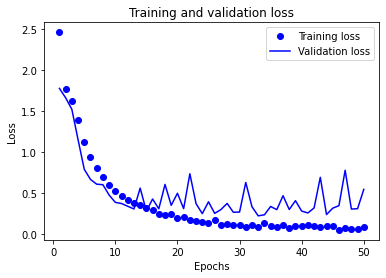

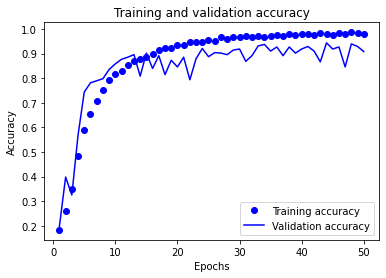

In [66]:
plt.rcParams["figure.figsize"] = (6,4)
plot_loss(history_proposed)
plot_acc(history_proposed)

### 2.3 Evaluating the test accuracy of the proposed model

In [39]:
load_model_proposed = keras.models.load_model("../models/4_proposed.h5")
load_model_proposed.evaluate(test)

 5/15 [=========>....................] - ETA: 0s - loss: 0.2481 - accuracy: 0.9313

2022-08-31 04:16:17.085838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 12ms/step - loss: 0.1766 - accuracy: 0.9563


[0.1765802949666977, 0.9562500715255737]

---

*Test Accuracy*: **95.63%**

---

### 2.4 Confusion matrix and class-wise precious and recall for proposed model

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        80
           1       0.93      0.89      0.91        80
           2       0.92      0.97      0.95        80
           3       0.95      0.89      0.92        80
           4       0.83      0.99      0.90        80
           5       0.97      0.78      0.86        80

    accuracy                           0.92       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.92      0.92       480



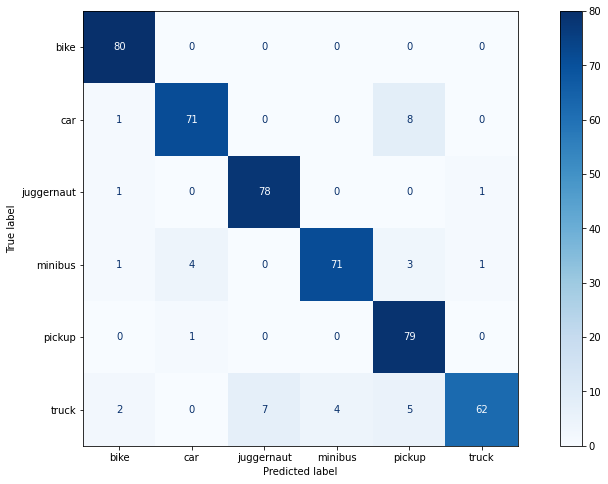

In [49]:
proposed_labels, proposed_preds = get_preds_labels(model_proposed, test)
cm_proposed = confusion_matrix(proposed_labels, proposed_preds)
print_cm(proposed_labels, proposed_preds, cm_proposed)